In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import MinMaxScaler

In [ ]:
df = pd.read_excel('/content/FINALDATA.xlsx', parse_dates=['Date'])

In [ ]:
bond_yield = 'US TBill 10Y Yield(%)'

In [ ]:
# Create lag features
df['Yield_lag1'] = df[bond_yield].shift(1)
df['Yield_lag3'] = df[bond_yield].shift(3)
df['Yield_lag6'] = df[bond_yield].shift(6)

df['Yield_ma3'] = df[bond_yield].rolling(window=3).mean()
df['Yield_ma6'] = df[bond_yield].rolling(window=6).mean()
df['Yield_ma12'] = df[bond_yield].rolling(window=12).mean()

df = df.dropna().reset_index(drop=True)

In [ ]:
df.tail()

,Date,US TBill 10Y Yield(%),Fed Funds Rate (%)_shifted(1M),Building permits(in thousands)_shifted(1M),German Bund Yield_shifted(1M),Consumer Sentiment Index_shifted(1M),Debt to GDP_shifted(1M),Crude Oil Front Month Future (USD/bbl)_shifted(1M),S&P 500(%)_shifted(1M),Economic_Stress_shifted(1M),Yield_lag1,Yield_lag3,Yield_lag6,Yield_ma3,Yield_ma6,Yield_ma12
390,2024-08-01,3.9034,5.33,1406,2.304,66.4,-5.445,77.91,1.132135,430.58064,4.0296,4.4985,4.2502,4.109700,4.284617,4.298133
391,2024-09-01,3.7809,5.33,1470,2.299,67.9,-7.044,73.55,2.283469,432.68232,3.9034,4.3961,4.2003,3.904633,4.214717,4.232283
392,2024-10-01,4.2844,5.13,1425,2.123,70.1,-6.244,68.17,2.019687,420.64114,3.7809,4.0296,4.6798,3.989567,4.148817,4.178425
393,2024-11-01,4.1685,4.83,1419,2.390,70.5,-6.894,69.26,-0.989678,419.29429,4.2844,3.9034,4.4985,4.077933,4.093817,4.165267
394,2024-12-01,4.5690,4.64,1493,2.088,71.8,-7.072,68.00,5.730135,428.49702,4.1685,3.7809,4.3961,4.340633,4.122633,4.222758


In [ ]:
X = df.drop(columns=['Date', bond_yield])
y = df[bond_yield]

In [ ]:
X.tail()

,Fed Funds Rate (%)_shifted(1M),Building permits(in thousands)_shifted(1M),German Bund Yield_shifted(1M),Consumer Sentiment Index_shifted(1M),Debt to GDP_shifted(1M),Crude Oil Front Month Future (USD/bbl)_shifted(1M),S&P 500(%)_shifted(1M),Economic_Stress_shifted(1M),Yield_lag1,Yield_lag3,Yield_lag6,Yield_ma3,Yield_ma6,Yield_ma12
390,5.33,1406,2.304,66.4,-5.445,77.91,1.132135,430.58064,4.0296,4.4985,4.2502,4.109700,4.284617,4.298133
391,5.33,1470,2.299,67.9,-7.044,73.55,2.283469,432.68232,3.9034,4.3961,4.2003,3.904633,4.214717,4.232283
392,5.13,1425,2.123,70.1,-6.244,68.17,2.019687,420.64114,3.7809,4.0296,4.6798,3.989567,4.148817,4.178425
393,4.83,1419,2.390,70.5,-6.894,69.26,-0.989678,419.29429,4.2844,3.9034,4.4985,4.077933,4.093817,4.165267
394,4.64,1493,2.088,71.8,-7.072,68.00,5.730135,428.49702,4.1685,3.7809,4.3961,4.340633,4.122633,4.222758


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [ ]:
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

In [ ]:
X_train_normalized_df = pd.DataFrame(X_train_normalized, columns=X_train.columns, index=X_train.index)
X_test_normalized_df = pd.DataFrame(X_test_normalized, columns=X_test.columns, index=X_test.index)

In [ ]:
param_grid = {
    'n_estimators': [800],
    'max_depth': [3],
    'learning_rate': [0.1],
    'subsample': [0.8],
    'colsample_bytree': [1.0],
    'reg_alpha': [0],
    'reg_lambda': [1],
    'gamma': [0.2]
}

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)

model = XGBRegressor(random_state=42)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train_normalized_df, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, imp...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [1.0], 'gamma': [0.2],
                         'learning_rate': [0.1], 'max_depth': [3],
                         'n_estimators': [800], 'reg_alpha': [0],
                         'reg_lambda': [1], 'subsample': [0.8]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [ ]:
best_model = grid_search.best_estimator_

y_train_pred = best_model.predict(X_train_normalized_df)
y_test_pred = best_model.predict(X_test_normalized_df)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

train_dates = df['Date'].iloc[y_train.index]
test_dates = df['Date'].iloc[y_test.index]

In [ ]:
def weighted_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true)) * 100

train_wmape = weighted_mape(y_train, y_train_pred)
test_wmape = weighted_mape(y_test, y_test_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

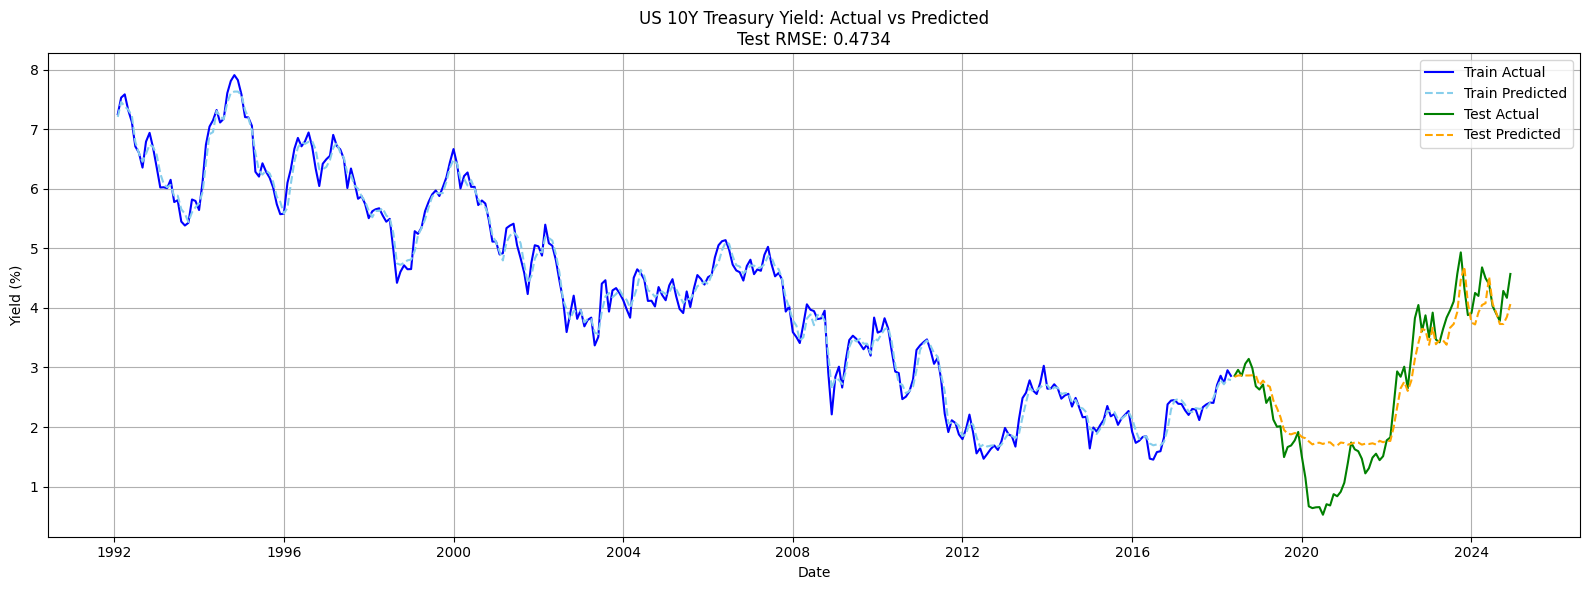

In [ ]:
plt.figure(figsize=(16, 6))
plt.plot(train_dates, y_train, label='Train Actual', color='blue')
plt.plot(train_dates, y_train_pred, label='Train Predicted', color='skyblue', linestyle='--')
plt.plot(test_dates, y_test, label='Test Actual', color='green')
plt.plot(test_dates, y_test_pred, label='Test Predicted', color='orange', linestyle='--')
plt.title(f'US 10Y Treasury Yield: Actual vs Predicted\nTest RMSE: {test_rmse:.4f}')
plt.xlabel('Date')
plt.ylabel('Yield (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

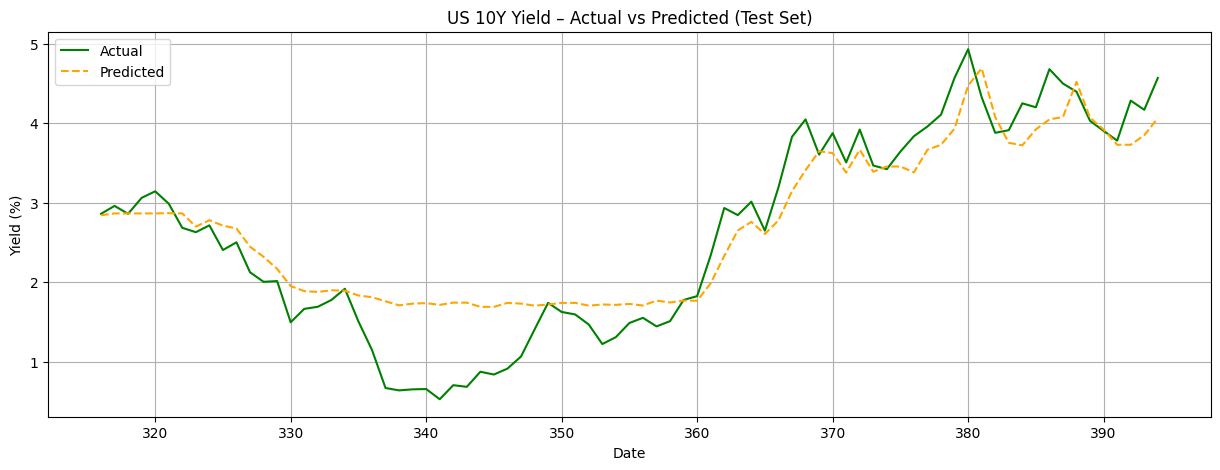

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(y_test.index, y_test.values, label='Actual', color='green')
plt.plot(y_test.index, y_test_pred, label='Predicted', color='orange', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Yield (%)')
plt.title('US 10Y Yield – Actual vs Predicted (Test Set)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
print("Best Parameters:", grid_search.best_params_)
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Train MAE: {train_mae:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Train R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")
print(f"Train WMAPE: {train_wmape:.2f}%")
print(f"Test WMAPE: {test_wmape:.2f}%")

Best Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 800, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.8}
Train RMSE: 0.1509
Test RMSE: 0.4734
Train MAE: 0.1189
Test MAE: 0.3591
Train R²: 0.9921
Test R²: 0.8600
Train WMAPE: 2.76%
Test WMAPE: 13.71%


In [ ]:
params_df = pd.DataFrame(list(grid_search.best_params_.items()), columns=['Parameter', 'Value'])
print(params_df.to_string(index=False))

       Parameter  Value
colsample_bytree    1.0
           gamma    0.2
   learning_rate    0.1
       max_depth    3.0
    n_estimators  800.0
       reg_alpha    0.0
      reg_lambda    1.0
       subsample    0.8


In [ ]:
print(X_train_normalized_df.columns)

Index(['Fed Funds Rate (%)_shifted(1M)',
       'Building permits(in thousands)_shifted(1M)',
       'German Bund Yield_shifted(1M)', 'Consumer Sentiment Index_shifted(1M)',
       'Debt to GDP_shifted(1M)',
       'Crude Oil Front Month Future (USD/bbl)_shifted(1M)',
       'S&P 500(%)_shifted(1M)', 'Economic_Stress_shifted(1M)', 'Yield_lag1',
       'Yield_lag3', 'Yield_lag6', 'Yield_ma3', 'Yield_ma6', 'Yield_ma12'],
      dtype='object')


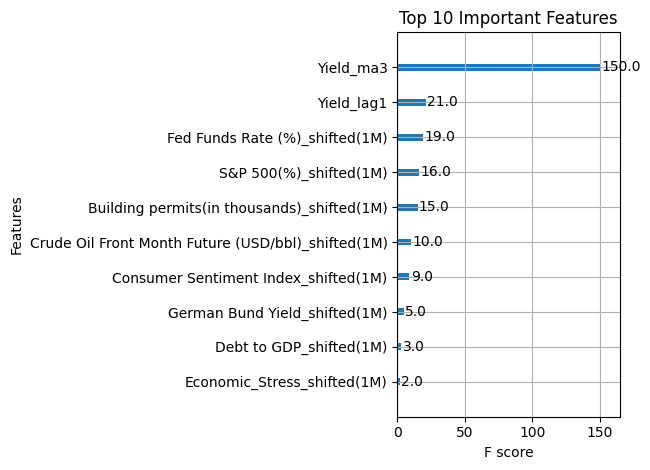

In [ ]:
plot_importance(best_model, max_num_features=10, importance_type='weight')
plt.title("Top 10 Important Features")
plt.tight_layout()
plt.show()

In [ ]:
import shap

# Use your trained model: e.g., best_model_xgb or best_model_ada
explainer = shap.Explainer(best_model)  # or use TreeExplainer for older SHAP versions
shap_values = explainer(X_test_normalized_df)

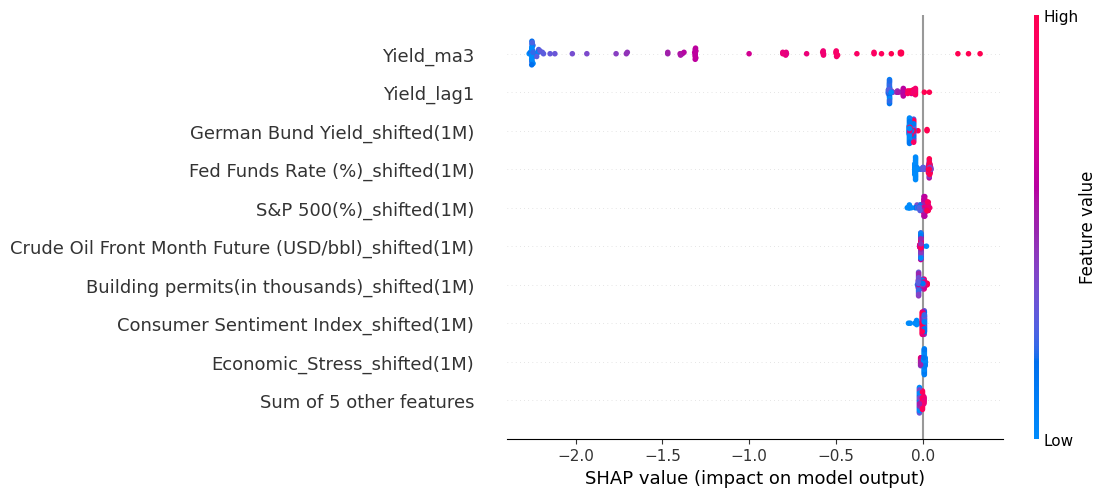

In [ ]:
shap.plots.beeswarm(shap_values, max_display=10)  # Top 10 features

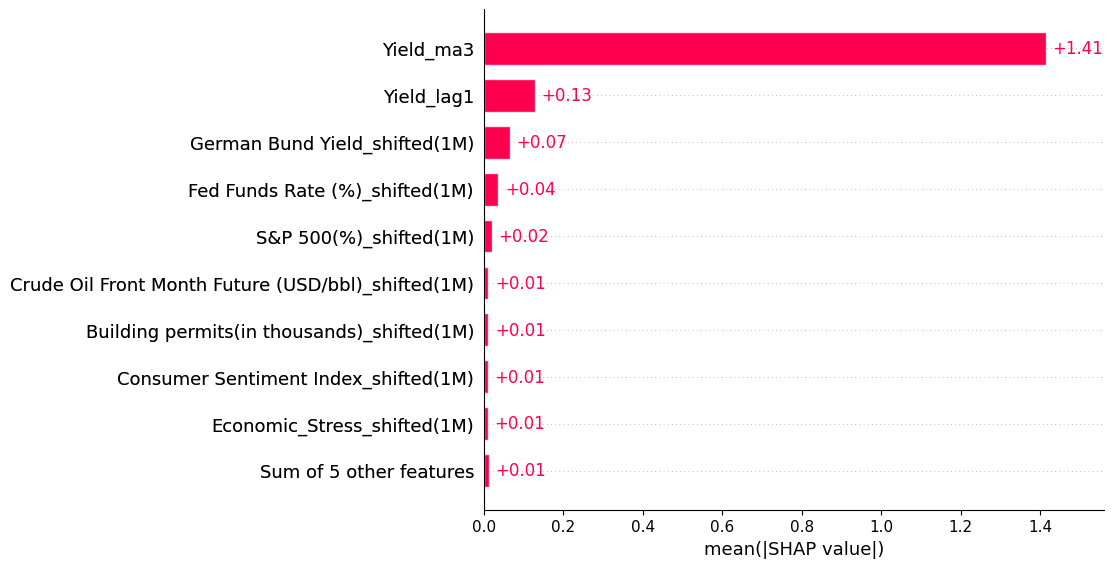

In [ ]:
shap.plots.bar(shap_values, max_display=10)

In [ ]:
shap.summary_plot(shap_values, X_test_normalized_df, plot_type="bar")

# Change the bar color (default uses red)
bars = plt.gca().patches
for bar in bars:
    bar.set_color('#1f77b4')  # Use your preferred hex color
plt.title("SHAP Feature Importance (Custom Color)")
plt.tight_layout()
plt.show()

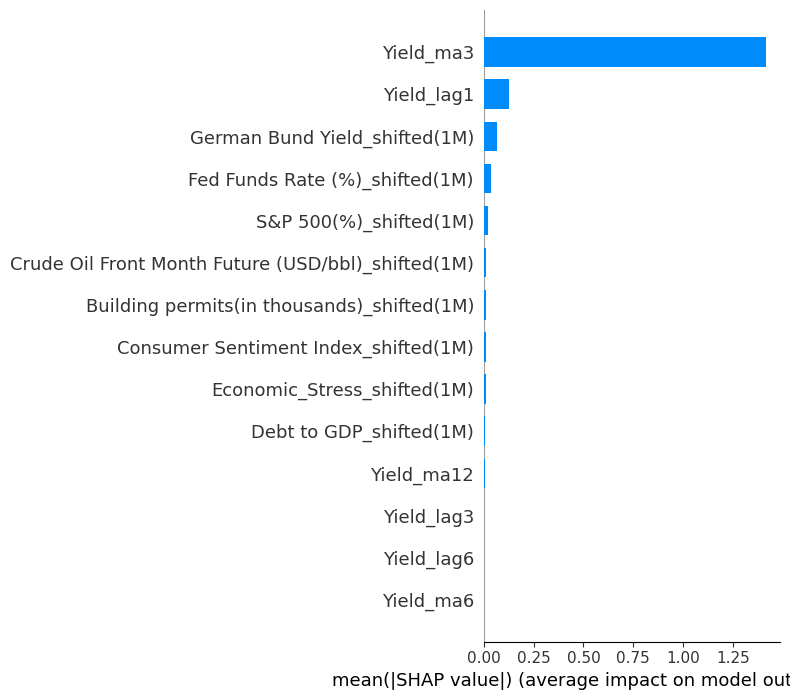

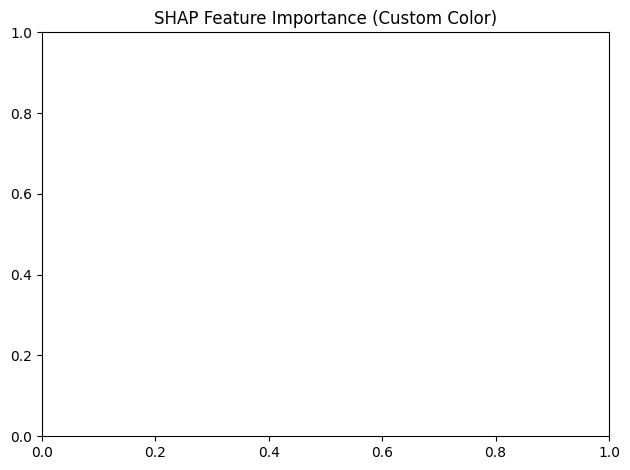

In [ ]:
shap.summary_plot(shap_values, X_test_normalized_df, plot_type="bar")

# Change the bar color (default uses red)
bars = plt.gca().patches
for bar in bars:
    bar.set_color('#1f77b4')  # Use your preferred hex color
plt.title("SHAP Feature Importance (Custom Color)")
plt.tight_layout()
plt.show()

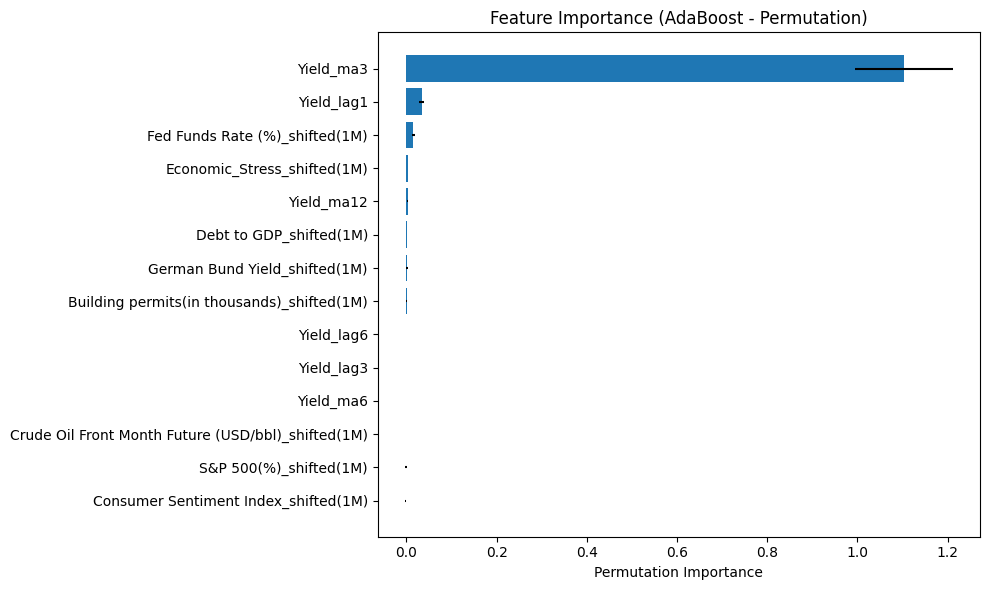

In [ ]:
from sklearn.inspection import permutation_importance
import pandas as pd
import matplotlib.pyplot as plt

# Make sure X_test is a DataFrame with column names
X_test_normalized_df = pd.DataFrame(X_test_normalized_df, columns=X.columns)

# Get permutation importance scores
result = permutation_importance(best_model, X_test_normalized_df, y_test, n_repeats=30, random_state=42)

# Create a sorted importance DataFrame
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance Mean': result.importances_mean,
    'Importance Std': result.importances_std
}).sort_values(by='Importance Mean', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance Mean'], xerr=importance_df['Importance Std'])
plt.xlabel("Permutation Importance")
plt.title("Feature Importance (AdaBoost - Permutation)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [ ]:
# Round for clean viewing
importance_df_rounded = importance_df.copy()
importance_df_rounded['Importance Mean'] = importance_df_rounded['Importance Mean'].round(5)
importance_df_rounded['Importance Std'] = importance_df_rounded['Importance Std'].round(5)

# Display top N features
display(importance_df_rounded.head(10))

,Feature,Importance Mean,Importance Std
11,Yield_ma3,1.10249,0.10850
8,Yield_lag1,0.03349,0.00489
0,Fed Funds Rate (%)_shifted(1M),0.01536,0.00281
7,Economic_Stress_shifted(1M),0.00329,0.00054
13,Yield_ma12,0.00241,0.00046
4,Debt to GDP_shifted(1M),0.00155,0.00062
2,German Bund Yield_shifted(1M),0.00137,0.00197
1,Building permits(in thousands)_shifted(1M),0.00027,0.00071
10,Yield_lag6,0.00000,0.00000
9,Yield_lag3,0.00000,0.00000
